In [1]:
import pandas as pd
df=pd.read_csv('Fraud.csv')
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [2]:
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

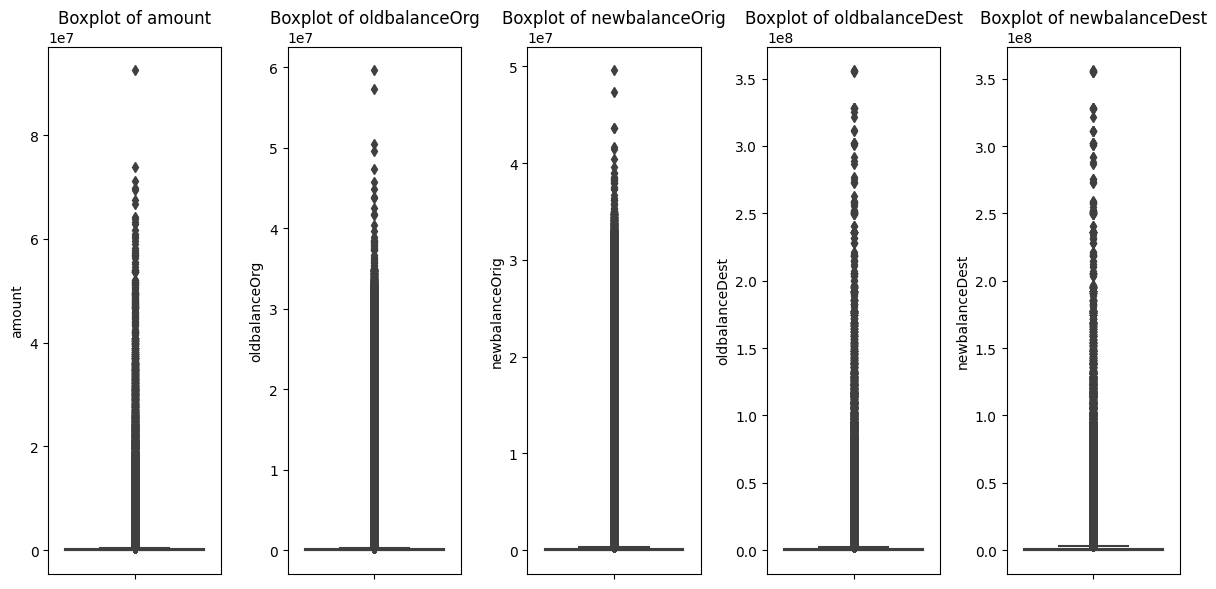

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

Since our dataset has no missing values and outliers, we can proceed directly with model training. By analyzing the features in the dataset, we choose XGBoost (Extreme Gradient Boosting) as the primary algorithm for fraud detection. XGBoost is known for its high accuracy, efficiency, and robustness in handling structured data, making it a perfect choice for this task.


Why XGBoost ?
Handles Imbalanced Data Efficiently – Since fraudulent transactions are rare compared to legitimate ones, XGBoost effectively learns patterns using weight balancing and boosting techniques.

Feature Importance Analysis – XGBoost identifies the most significant features, allowing us to interpret key factors influencing fraud.

Speed & Performance – Optimized for fast execution using parallel computing, making it scalable for large datasets.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

Selecting features 

step → Represents the time of the transaction (irrelevant for fraud, so it was excluded).

type → Categorical feature indicating transaction type (CASH_OUT, TRANSFER, etc.).

amount → Transaction amount (critical for fraud detection).

oldbalanceOrg, newbalanceOrig → Sender’s balance before & after the transaction.

oldbalanceDest, newbalanceDest → Receiver’s balance before & after the transaction.

isFraud → Target variable indicating fraud (0 = No fraud, 1 = Fraud).

isFlaggedFraud → A system-generated flag (mostly redundant, hence excluded)


In [7]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


Handling Categorical columns :

(One-Hot Encoding):

type_CASH_OUT

type_TRANSFER

type_PAYMENT

type_DEBIT

type_CASH_IN

Fraud mostly occurs in CASH_OUT and TRANSFER 

transactions, so these were particularly important.

In [8]:
encoder = OneHotEncoder()
type_encoded = encoder.fit_transform(df[['type']]).toarray()
type_columns = encoder.get_feature_names_out(['type'])
df = df.join(pd.DataFrame(type_encoded, columns=type_columns)).drop(['type'], axis=1)

Deriving new variables :

Balance Differences:

balance_diff_org = oldbalanceOrg - 

newbalanceOrig (amount deducted from sender)

balance_diff_dest = oldbalanceDest - 

newbalanceDest (amount received by recipient)

Transaction Ratio:

transaction_ratio = amount / (oldbalanceOrg + 1) → Helps identify unusually large transactions compared to available balance.

In [9]:
df['balance_diff_org'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_dest'] = df['oldbalanceDest'] - df['newbalanceDest']
df['transaction_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)

In [10]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,balance_diff_org,balance_diff_dest,transaction_ratio
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,9839.64,0.0,0.057834
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,1864.28,0.0,0.087731
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0.0,0.0,0.0,0.0,1.0,181.00,0.0,0.994505
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0.0,1.0,0.0,0.0,0.0,181.00,21182.0,0.994505
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,11668.14,0.0,0.280788


In [11]:
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [14]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

The key factors that predict fraudulent transactions in our model include transaction type, amount, balance behavior, and recipient account activity. Fraudulent transactions are most common in CASH_OUT and TRANSFER types, where money is withdrawn or transferred before detection. High transaction amounts, especially those close to the sender’s total balance, are strong indicators of fraud. The sender’s balance behavior is crucial—if their old balance is nearly equal to the transaction amount, leaving them with little or no funds, it suggests an attempt to empty the account. Additionally, fraudulent transactions often target new or inactive recipient accounts with a zero initial balance, and in many cases, the recipient’s balance remains unchanged after the transaction. A high transaction-to-balance ratio, where most or all of the sender’s funds are transferred, is another red flag. While flagged fraud cases exist, most fraud transactions bypass traditional detection systems, making these behavioral patterns critical for identifying suspicious activity.


In [15]:
y_pred = model.predict(X_test)


In [16]:
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.94      1.00      0.97      1643

    accuracy                           1.00   1272524
   macro avg       0.97      1.00      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524

AUC-ROC Score: 0.9981347290332236


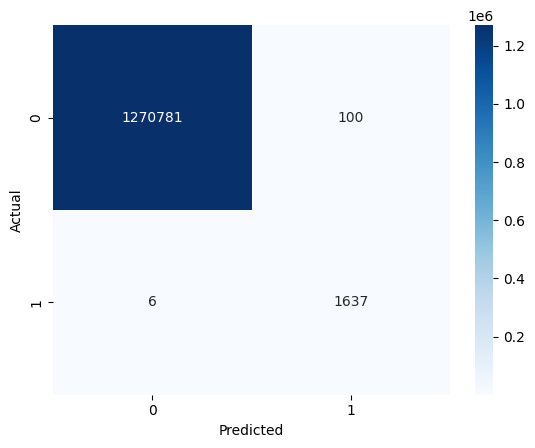

In [17]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler

# Load dataset (X_train should be your original training features)
scaler = StandardScaler()
scaler.fit(X_train)  # Fit the scaler with training data

StandardScaler()

In [19]:
import pickle

# Assuming 'model' is your trained machine learning model
with open("fraud_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("Model saved successfully!")


Model saved successfully!


In [20]:
from sklearn.preprocessing import StandardScaler

# Assuming 'scaler' was used for training
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

print("Scaler saved successfully!")

Scaler saved successfully!


In [21]:
print("Number of features used in training:", X_train.shape[1])


Number of features used in training: 14


In [22]:
print(X_train.columns)  # Check column names


Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'balance_diff_org',
       'balance_diff_dest', 'transaction_ratio'],
      dtype='object')


In [23]:
sample_transaction = pd.DataFrame({
    'step': [1],
    'amount': [10000],
    'oldbalanceOrg': [50000],
    'newbalanceOrig': [40000],
    'oldbalanceDest': [0],
    'newbalanceDest': [0],
    'balance_diff_org': [50000 - 40000],
    'balance_diff_dest': [0 - 0],
    'transaction_ratio': [10000 / (50000 + 1)]  # Prevent division by zero
})

# Encoding 'type' manually (Assume 'TRANSFER')
sample_transaction['type_CASH_IN'] = [0]
sample_transaction['type_CASH_OUT'] = [0]
sample_transaction['type_DEBIT'] = [0]
sample_transaction['type_PAYMENT'] = [0]
sample_transaction['type_TRANSFER'] = [1]  # Only 'TRANSFER' is 1

# Ensure column order matches the trained model
expected_columns = [
    'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
    'balance_diff_org', 'balance_diff_dest', 'transaction_ratio'
]

# Reorder the columns
sample_transaction = sample_transaction[expected_columns]

# Load trained model (ensure you have saved it as 'fraud_model.pkl')
import joblib
fraud_model = joblib.load("fraud_model.pkl")

# Predict
prediction = fraud_model.predict(sample_transaction)

print("Fraud Prediction:", "Fraudulent" if prediction[0] == 1 else "Not Fraudulent")

Fraud Prediction: Not Fraudulent


In [24]:
import pandas as pd
import joblib

# Load trained model
fraud_model = joblib.load("fraud_model.pkl")

# Create a sample fraudulent transaction (TRANSFER type)
fraud_sample = pd.DataFrame({
    'step': [100],  # Random time step
    'amount': [500000],  # Large transaction amount
    'oldbalanceOrg': [500000],  # High sender balance
    'newbalanceOrig': [0],  # Sender balance drained
    'oldbalanceDest': [0],  # Destination account has no initial balance
    'newbalanceDest': [0],  # No change in destination balance (possible fraud)
    'balance_diff_org': [500000 - 0],  # Large difference in sender balance
    'balance_diff_dest': [0 - 0],  # No change in receiver balance
    'transaction_ratio': [500000 / (500000 + 1)]  # Almost 1 (high transaction ratio)
})

# One-hot encode 'type' (TRANSFER)
fraud_sample['type_CASH_IN'] = [0]
fraud_sample['type_CASH_OUT'] = [0]
fraud_sample['type_DEBIT'] = [0]
fraud_sample['type_PAYMENT'] = [0]
fraud_sample['type_TRANSFER'] = [1]  # Only TRANSFER is 1

# Reorder columns to match model training
expected_columns = [
    'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
    'balance_diff_org', 'balance_diff_dest', 'transaction_ratio'
]
fraud_sample = fraud_sample[expected_columns]

# Predict
prediction = fraud_model.predict(fraud_sample)
print("Fraud Prediction:", "Fraudulent" if prediction[0] == 1 else "Not Fraudulent")

Fraud Prediction: Fraudulent


The sender transfers ALL their money and has zero balance left.

The receiver's balance does not increase, meaning the money might be disappearing (fraudulent behavior).

In [25]:
fraud_sample2 = pd.DataFrame({
    'step': [200],  # Another random time step
    'amount': [700000],  # Large cash-out amount
    'oldbalanceOrg': [700000],  # High sender balance
    'newbalanceOrig': [0],  # Sender's balance goes to zero
    'oldbalanceDest': [10000],  # Receiver had some balance
    'newbalanceDest': [101000],  # Receiver's balance increased unusually
    'balance_diff_org': [700000 - 0],  
    'balance_diff_dest': [101000 - 10000],  
    'transaction_ratio': [700000 / (700000 + 1)]  
})

# One-hot encode 'type' (CASH_OUT)
fraud_sample2['type_CASH_IN'] = [0]
fraud_sample2['type_CASH_OUT'] = [1]  # Only CASH_OUT is 1
fraud_sample2['type_DEBIT'] = [0]
fraud_sample2['type_PAYMENT'] = [0]
fraud_sample2['type_TRANSFER'] = [0]

# Reorder columns
fraud_sample2 = fraud_sample2[expected_columns]

# Predict
prediction2 = fraud_model.predict(fraud_sample2)
print("Fraud Prediction:", "Fraudulent" if prediction2[0] == 1 else "Not Fraudulent")

Fraud Prediction: Fraudulent


A very large cash-out transaction.

The sender’s balance drops to zero, meaning they are draining their account.

The receiver suddenly gains a huge amount of money, which could be suspicious.

To prevent fraudulent transactions while updating its infrastructure, the company should adopt
AI-Based Fraud Detection,
Multi-Factor Authentication (MFA),
Transaction Monitoring & Limits,
Account Behavior Analysis